In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 1. Load the Cats vs Dogs dataset (built-in)
(ds_train_raw, ds_val_raw, ds_test_raw), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],   # 80 % train / 15 % val /15% test
    with_info=True,
    shuffle_files=True,
    as_supervised=True                     
)

print("Dataset loaded ✅")
print("Train batches:", len(ds_train_raw))
print("Validation batches:", len(ds_val_raw))
print("Label names :", ds_info.features["label"].names)


Dataset loaded ✅
Train batches: 16283
Validation batches: 3490
Label names : ['cat', 'dog']


In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
# Load MobileNetV2 without top layer
base_model = MobileNetV2(input_shape=(160, 160, 3),
                         include_top=False,
                         weights='imagenet')


base_model.trainable = False


model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # binary classification
])


In [4]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Preprocessing function to resize and normalize
def preprocess(image, label):
    image = tf.image.resize(image, [160, 160])        # Resize to match MobileNetV2 input
    image = tf.cast(image, tf.float32) / 255.0        
    return image, label

# Apply preprocessing
train_dataset = ds_train_raw.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_val_raw.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = ds_test_raw.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 337s 649ms/step - accuracy: 0.9241 - loss: 0.1782 - val_accuracy: 0.9768 - val_loss: 0.0630
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 330s 648ms/step - accuracy: 0.9809 - loss: 0.0587 - val_accuracy: 0.9802 - val_loss: 0.0575
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 285s 560ms/step - accuracy: 0.9827 - loss: 0.0513 - val_accuracy: 0.9799 - val_loss: 0.0576
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 276s 542ms/step - accuracy: 0.9836 - loss: 0.0471 - val_accuracy: 0.9814 - val_loss: 0.0560
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 271s 533ms/step - accuracy: 0.9856 - loss: 0.0446 - val_accuracy: 0.9808 - val_loss: 0.0563


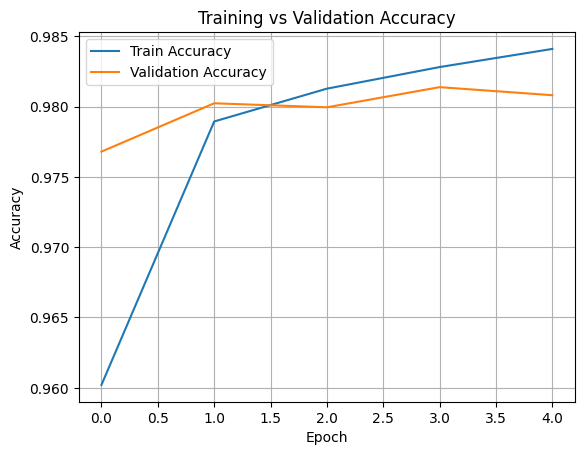

In [5]:
#Training vs Validation Accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


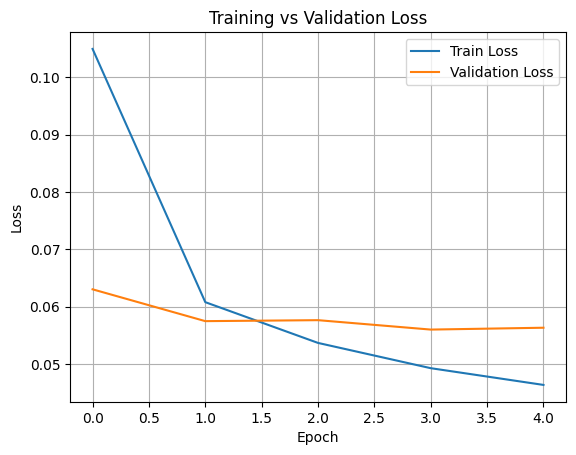

In [6]:
#Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


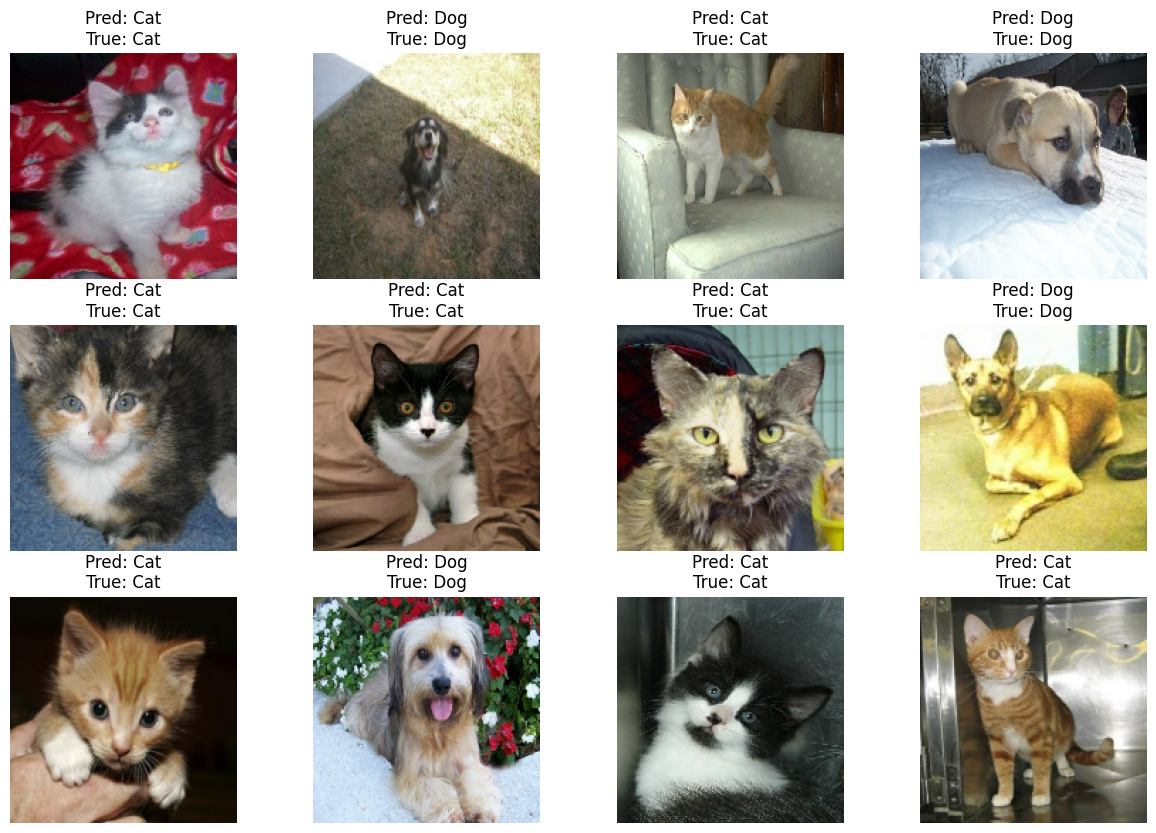

In [7]:
# Predict
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)  # returns probabilities
    break

# Convert probabilities to 0 (cat) or 1 (dog)
import numpy as np
predicted_labels = np.where(predictions > 0.5, 1, 0)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(12):  # Show first 12 images in the batch
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy())
    title = f"Pred: {'Dog' if predicted_labels[i] else 'Cat'}\nTrue: {'Dog' if labels[i] else 'Cat'}"
    plt.title(title)
    plt.axis("off")
